# Import the necessary librays

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
import mimetypes
import argparse
import imutils
import os


In [2]:
# Define the path to the directory containing training images
IMAGES_PATH = os.path.sep.join(["training_images"])

# Define the path to the CSV file containing annotations for bounding boxes
ANNOTS_PATH = os.path.sep.join(["train_solution_bounding_boxes.csv"])


In [3]:
# Define the base output directory
BASE_OUTPUT = "output"

# Create the base output directory if it doesn't exist
os.makedirs(BASE_OUTPUT, exist_ok=True)

# Define the path to save the trained model
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])

# Define the path to save the plot of training history
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

# Define the path to save the list of test image filenames
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])


# loading dataset

In [4]:
# Read the contents of the annotations CSV file and split it into rows
rows = open(ANNOTS_PATH).read().strip().split("\n")

# Initialize lists to store data, targets, and filenames
data = []
targets = []
filenames = []


In [5]:
rows[:5]

['image,xmin,ymin,xmax,ymax',
 'vid_4_1000.jpg,281.2590449,187.0350708,327.7279305,223.225547',
 'vid_4_10000.jpg,15.16353111,187.0350708,120.3299566,236.4301802',
 'vid_4_10040.jpg,239.1924747,176.7648005,361.9681621,236.4301802',
 'vid_4_10020.jpg,496.4833575,172.3632561,630.0202605,231.5395753']

# loop over the rows

In [6]:
# Iterate through each row in the annotations data starting from the second row
for row in rows[1:]:
    # Split the row into individual values
    row = row.split(",")
    # Extract filename, bounding box coordinates (startX, startY, endX, endY)
    (filename, startX, startY, endX, endY) = row
    # Construct the path to the image
    imagePath = os.path.join(IMAGES_PATH, filename)
    # Read the image using OpenCV
    image = cv2.imread(imagePath)
    # Get the height and width of the image
    (h, w) = image.shape[:2]
    # Normalize the bounding box coordinates
    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h
    # Load and preprocess the image using Keras
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    # Append the preprocessed image, target coordinates, and filename to their respective lists
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)


In [7]:
data[:2]

[array([[[127., 210., 254.],
         [127., 210., 254.],
         [128., 211., 255.],
         ...,
         [ 97., 181., 251.],
         [100., 186., 247.],
         [100., 183., 249.]],
 
        [[129., 212., 254.],
         [128., 211., 255.],
         [129., 212., 255.],
         ...,
         [104., 182., 255.],
         [107., 179., 251.],
         [104., 182., 255.]],
 
        [[129., 212., 254.],
         [129., 212., 254.],
         [129., 212., 254.],
         ...,
         [102., 184., 255.],
         [104., 181., 255.],
         [103., 183., 252.]],
 
        ...,
 
        [[ 29.,  53.,  81.],
         [ 27.,  50.,  81.],
         [ 27.,  50.,  81.],
         ...,
         [ 22.,  44.,  68.],
         [ 21.,  43.,  67.],
         [ 22.,  44.,  68.]],
 
        [[ 28.,  51.,  82.],
         [ 28.,  52.,  80.],
         [ 29.,  53.,  81.],
         ...,
         [ 21.,  43.,  67.],
         [ 21.,  43.,  67.],
         [ 21.,  43.,  67.]],
 
        [[ 28.,  51.,  82.],
 

In [8]:
targets[:5]

[(0.416063675887574, 0.4921975547368421, 0.4848046309171598, 0.58743565),
 (0.022431259038461538,
  0.4921975547368421,
  0.17800289437869823,
  0.6221846847368421),
 (0.35383502174556214,
  0.46517052763157896,
  0.5354558610946745,
  0.6221846847368421),
 (0.7344428365384615,
  0.4535875160526316,
  0.9319826338757395,
  0.6093146718421053),
 (0.02460202605029586,
  0.49091055342105266,
  0.19609261937869824,
  0.6273326897368421)]

In [9]:
filenames[:5]

['vid_4_1000.jpg',
 'vid_4_10000.jpg',
 'vid_4_10040.jpg',
 'vid_4_10020.jpg',
 'vid_4_10060.jpg']

# Split the dataset

In [10]:
# Convert the list of images to a NumPy array and normalize pixel values
data = np.array(data, dtype="float32") / 255.0

# Convert the list of targets to a NumPy array
targets = np.array(targets, dtype="float32")

# Split the data into training and testing sets along with filenames
split = train_test_split(data, targets, filenames, test_size=0.10, random_state=42)
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# Save the list of testing filenames to a file
with open(TEST_FILENAMES, "w") as f:
    f.write("\n".join(testFilenames))


In [11]:
trainImages[:2]

array([[[[0.41960785, 0.6862745 , 0.9254902 ],
         [0.42352942, 0.6901961 , 0.9372549 ],
         [0.42745098, 0.69411767, 0.9411765 ],
         ...,
         [0.4117647 , 0.6509804 , 0.90588236],
         [0.4117647 , 0.6509804 , 0.90588236],
         [0.4117647 , 0.6509804 , 0.90588236]],

        [[0.42352942, 0.6901961 , 0.9372549 ],
         [0.43529412, 0.7019608 , 0.9490196 ],
         [0.43137255, 0.69803923, 0.94509804],
         ...,
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ]],

        [[0.43137255, 0.69803923, 0.94509804],
         [0.43529412, 0.7019608 , 0.9490196 ],
         [0.4392157 , 0.7058824 , 0.9529412 ],
         ...,
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ],
         [0.41568628, 0.654902  , 0.9098039 ]],

        ...,

        [[0.10196079, 0.09803922, 0.11764706],
         [0.16862746, 0.15294118, 0.10980392]

In [12]:
trainTargets[:5]

array([[6.1505067e-01, 4.7417954e-01, 7.8219968e-01, 5.8743566e-01],
       [8.9507961e-01, 4.6388352e-01, 1.0000000e+00, 5.7456565e-01],
       [7.2358898e-04, 5.1793760e-01, 9.4066568e-02, 5.9901863e-01],
       [3.8494936e-01, 5.1793760e-01, 5.6005788e-01, 6.2347168e-01],
       [5.3095412e-01, 4.9469721e-01, 6.3947558e-01, 5.8148479e-01]],
      dtype=float32)

In [13]:
trainFilenames[:5]

['vid_4_6440.jpg',
 'vid_4_2080.jpg',
 'vid_4_2060.jpg',
 'vid_4_23000.jpg',
 'vid_4_8680.jpg']

In [14]:
testFilenames[:4]

['vid_4_17540.jpg', 'vid_4_6360.jpg', 'vid_4_12300.jpg', 'vid_4_21240.jpg']

# Building the model architecture

In [15]:
# Load the VGG16 model pretrained on ImageNet, excluding the fully connected layers
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the weights of the pretrained VGG16 model
vgg.trainable = False

# Get the output of the VGG16 model
flatten = vgg.output

# Flatten the output of the VGG16 model
flatten = Flatten()(flatten)

# Add fully connected layers for bounding box regression
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# Create a model that takes VGG16's input and predicts bounding box coordinates
model = Model(inputs=vgg.input, outputs=bboxHead)


In [16]:
# Initialize the learning rate
INIT_LR = 1e-4

# Define the number of epochs for training
NUM_EPOCHS = 20

# Define the batch size for training
BATCH_SIZE = 32


In [17]:
# Initialize the Adam optimizer with the specified learning rate
opt = Adam(lr=INIT_LR)

# Compile the model with mean squared error loss and the Adam optimizer
model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])

# Print the summary of the model architecture
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Train the model

In [18]:
# Train the model on the training data with validation on the testing data
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    shuffle=True,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1
)


Epoch 1/20



16/16 [==============================] - 52s 3s/step - loss: 0.0627 - accuracy: 0.3579 - val_loss: 0.0441 - val_accuracy: 0.4464
Epoch 2/20
16/16 [==============================] - 53s 3s/step - loss: 0.0394 - accuracy: 0.5726 - val_loss: 0.0456 - val_accuracy: 0.5000
Epoch 3/20
16/16 [==============================] - 59s 4s/step - loss: 0.0334 - accuracy: 0.6243 - val_loss: 0.0441 - val_accuracy: 0.5893
Epoch 4/20
16/16 [==============================] - 62s 4s/step - loss: 0.0308 - accuracy: 0.6978 - val_loss: 0.0580 - val_accuracy: 0.5714
Epoch 5/20
16/16 [==============================] - 64s 4s/step - loss: 0.0286 - accuracy: 0.7555 - val_loss: 0.0447 - val_accuracy: 0.5893
Epoch 6/20
16/16 [==============================] - 64s 4s/step - loss: 0.0272 - accuracy: 0.6978 - val_loss: 0.0486 - val_accuracy: 0.6071
Epoch 7/20
16/16 [==============================] - 68s 4s/step - loss: 0.0267 - accuracy: 0.7416 - val_loss: 0.0457 - val_accuracy: 0.6786
Epoch 8/20
16/16 [=============

In [19]:
#saving object detector model
model.save(MODEL_PATH, save_format="h5")

# Plot the training and validation loss over epochs

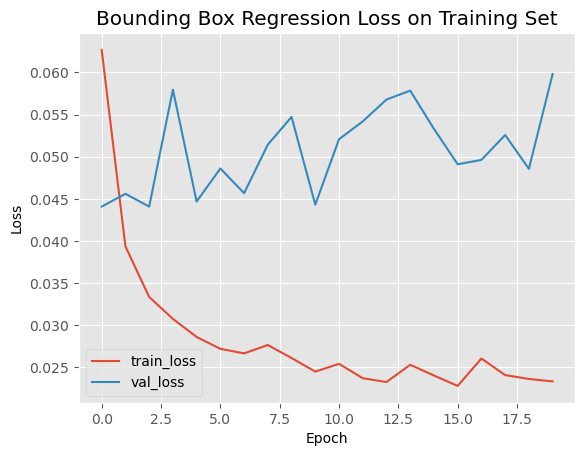

In [20]:
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)


In [21]:
#loading object detector
model = load_model(MODEL_PATH)

# Make predictions using the trained model

1/1 [==============================] - 0s 240ms/step


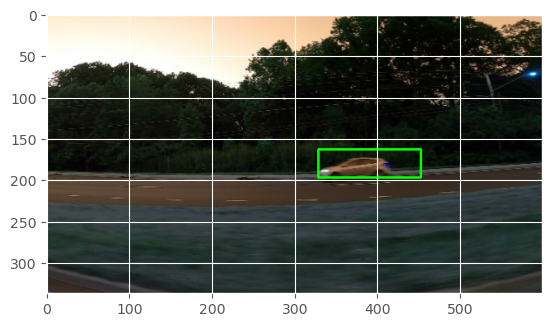

In [22]:
# Define the path to the testing image
imagePath = "testing_images/vid_5_29460.jpg"

# Load and preprocess the testing image
image = load_img(imagePath, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Make predictions using the trained model
preds = model.predict(image)[0]

# Extract predicted bounding box coordinates
(startX, startY, endX, endY) = preds

# Read the original image and resize it
image = cv2.imread(imagePath)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# Scale the predicted coordinates to match the resized image
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

# Draw the bounding box on the image
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

# Display the image with the bounding box
plt.imshow(image)
